<a href="https://colab.research.google.com/github/leewaygroups/GT_ML_2020/blob/master/supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SUPERVISED LEARNING**: 



# PROBLEM 1: 
Detection of fraudulent transactions in a mobile money service implemented inan African country.

In [ ]:
'''
STEP 1:
Import dependencies
'''
# data manipulation
import numpy as np
import pandas as pd

# viz
import seaborn as sns
import matplotlib.pyplot as plt
# from scipy import stats

# misc
from time import time
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import  StratifiedKFold
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score
from sklearn.metrics import  f1_score
from sklearn.metrics import roc_auc_score

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import  MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import  SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
'''
STEP 2:
Load raw dataset from csv file
''' 
df_raw = pd.read_csv('mobile_money_trans.csv').drop(columns=['Unnamed: 0']) 
df_raw.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,destCatig
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,C
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,C
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,C
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,C
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,C


In [ ]:
'''
STEP 3: 
Clean and split data into train test set
''' 
df_raw['destCatig'] = df_raw['nameDest'].str[0]
df = df_raw[['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'destCatig', 'isFraud']]
# df = df_raw[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'destCatig', 'isFraud']]

# generate binary values using get_dummies
dum_df = pd.get_dummies(df, columns=["type"], prefix=["type"] )
dum_df = pd.get_dummies(dum_df, columns=['destCatig'], prefix=['destCatig'])

# clean dataset
X = dum_df.drop(['isFraud', 'destCatig_M'], axis=1)
y = dum_df['isFraud']

# Split dataset into train test set. Note that the the split is stratified by label.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=20, shuffle=True)

df_raw.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
destCatig         0
dtype: int64

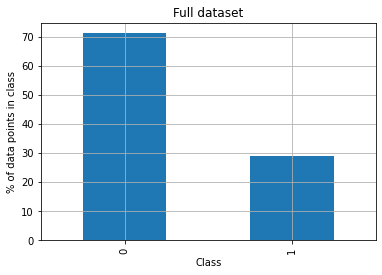

In [ ]:
'''
STEP 4:
Double check class distribution in entire dataset
'''
mycolor = 'rgbkymc'
round((dum_df['isFraud'].value_counts()/len(dum_df['isFraud'])) * 100, 2).plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('% of data points in class')
plt.title('Full dataset')
plt.grid()

In [ ]:
'''
STEP 5:
Setp pipelines for models. This is the benchmark model
'''
# helper functions
def init_MLPClassifier(max_iter=200, activation='relu', l_rate=0.001, rand_state=87):
  mlp = MLPClassifier(hidden_layer_sizes=(12,12), 
                   learning_rate_init=l_rate, 
                   solver='adam', 
                   activation=activation,
                   batch_size = 200,
                   max_iter = max_iter,
                   random_state=rand_state)
  
  return mlp

#model instantiation
model_names = ['DecisionTree', 'NeuralNet', 'Boosting', 'SVC', 'KNN']
classifiers = [
               Pipeline([
                        ('scaler', StandardScaler()),
                        ('dtc', DecisionTreeClassifier(criterion='gini', random_state=1))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('mlp', init_MLPClassifier(l_rate=0.001, rand_state=87))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('gbc', GradientBoostingClassifier(random_state=13))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('svc', SVC(C=1, kernel='rbf', random_state=81))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier(n_neighbors=5))
               ])
               ]

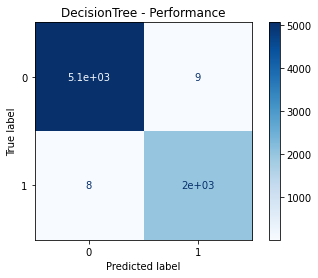

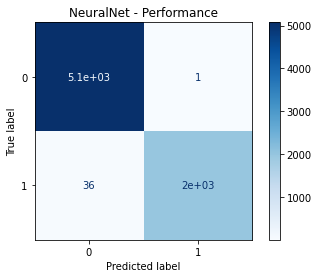

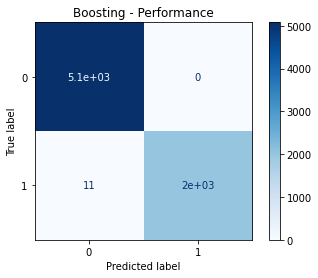

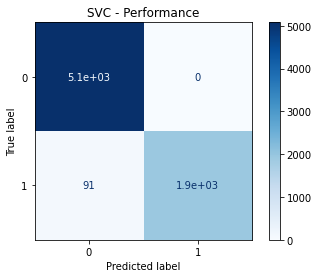

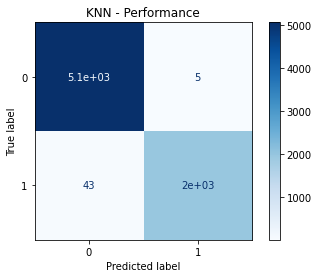

In [ ]:
'''
STEP  6:
Train, test and visualize confusion matrix of models.
'''

train_scores = []
test_scores = []
test_auc = []
train_time = []
test_time = []

for name, clf in zip(model_names, classifiers):
  t0=time()
  clf.fit(X_train, y_train)
  train_time.append(round(time()-t0, 3))

  t0=time()
  clf.score(X_test, y_test)
  test_time.append(round(time()-t0, 3))

  train_scores.append(clf.score(X_train, y_train))
  test_scores.append(clf.score(X_test, y_test))
  test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

  disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues
                                # normalize='pred'
                                )
  disp.ax_.set_title(name + ' - Performance')

In [ ]:
'''
STEP 7: 
Model evaluation
'''
# Accuracy of models
pd.DataFrame([train_scores, test_scores, test_auc, train_time, test_time], 
             columns=['DecisionTree', 'NeuralNet', 'Boosting', 'SVC', 'KNN'], 
             index=['Train', 'Test', 'ROC_AUC', 'Training Time', 'Test Time']
             )

,DecisionTree,NeuralNet,Boosting,SVC,KNN
Train,1.000000,0.996105,0.999484,0.989347,0.995495
Test,0.997607,0.994792,0.998452,0.987190,0.993243
ROC_AUC,0.997139,0.991017,0.997285,0.977542,0.988896
Training Time,0.066000,5.441000,3.315000,1.317000,0.255000
Test Time,0.005000,0.007000,0.016000,0.270000,0.439000


### Tuning Models Parameters

STEP 8 - tuning individual models






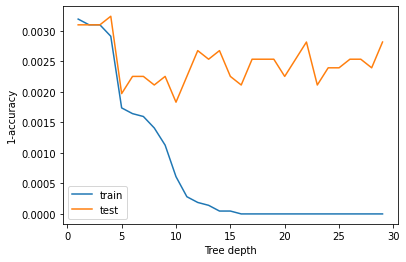

In [ ]:
'''
DecisionTreeClassifier Tuning
'''
feature_imp = []
result = []
for idx in range(1,30):
  clf = DecisionTreeClassifier(criterion='gini', max_depth=idx)
  clf.fit(X_train, y_train)
  train_score = clf.score(X_train, y_train)
  test_score = clf.score(X_test, y_test)

  feature_imp.append(clf.feature_importances_)
  result.append([idx, train_score, test_score])

# view
result = pd.DataFrame(result, columns=['depth','train_score','test_score'])

plt.plot(result['depth'], 1-result['train_score'])
plt.plot(result['depth'], 1-result['test_score'])

plt.legend(['train', 'test'], loc='lower left')
plt.xlabel('Tree depth')
plt.ylabel('1-accuracy')
plt.show()

# Derived optimum tree depth = 10

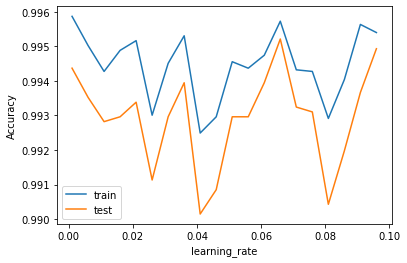

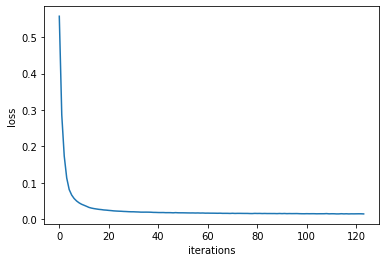

In [ ]:
'''
NeuralNet tuning
'''

mlp_result = []
count = 1
scl = StandardScaler()
X_tr = scl.fit_transform(X_train)
clfs = []

for idx in np.arange(0.001, 0.1, 0.005):
  count = count + 100
  clf = init_MLPClassifier(max_iter=200, l_rate=idx, rand_state=count)
  clf.fit(X_tr, y_train)

  clfs.append(clf)

  train_score = clf.score(X_tr, y_train)
  test_score = clf.score(scl.transform(X_test), y_test)

  mlp_result.append([idx, train_score, test_score])


mlp_result = pd.DataFrame(mlp_result, columns=['learning_rate','train_score','test_score'])

plt.plot(mlp_result['learning_rate'], mlp_result['train_score'])
plt.plot(mlp_result['learning_rate'], mlp_result['test_score'])

plt.legend(['train', 'test'], loc='lower left')
plt.xlabel('learning_rate')
plt.ylabel('Accuracy')
plt.show()

plt.plot(clfs[0].loss_curve_)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()


## Improving Bosting Model

In [ ]:
scl = StandardScaler()
X_tr = scl.fit_transform(X_train)
gb = GradientBoostingClassifier(random_state=5, subsample=1, max_depth=2)
gb.fit(X_tr, y_train)


train_score = gb.score(X_tr, y_train)
test_score = gb.score(scl.transform(X_test), y_test)

print(train_score, test_score)

0.9977943591909522 0.997043918918919


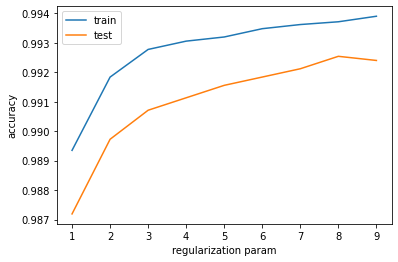

In [ ]:
'''
SVC Tuning
'''

feature_imp = []
result = []
for idx in range(1,10):
  clf = SVC(C=idx, probability=True)
  clf.fit(X_tr, y_train)
  train_score = clf.score(X_tr, y_train)
  test_score = clf.score(scl.transform(X_test), y_test)

  # feature_imp.append(clf.feature_importances_)
  result.append([idx, train_score, test_score])


result = pd.DataFrame(result, columns=['C','train_score','test_score'])

plt.plot(result['C'], result['train_score'])
plt.plot(result['C'], result['test_score'])

plt.legend(['train', 'test'], loc='upper left')
plt.xlabel('regularization param')
plt.ylabel('accuracy')
plt.show()

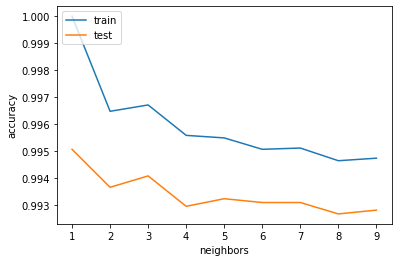

In [ ]:
'''
KNN tuning
'''

result = []
for idx in range(1,10, 1):
  clf = KNeighborsClassifier(n_neighbors=idx)
  clf.fit(X_tr, y_train)
  train_score = clf.score(X_tr, y_train)
  test_score = clf.score(scl.transform(X_test), y_test)

  # feature_imp.append(clf.feature_importances_)
  result.append([idx, train_score, test_score])


result = pd.DataFrame(result, columns=['C','train_score','test_score'])

plt.plot(result['C'], result['train_score'])
plt.plot(result['C'], result['test_score'])

plt.legend(['train', 'test'], loc='upper left')
plt.xlabel('neighbors')
plt.ylabel('accuracy')
plt.show()

In [ ]:
'''
STEP 9:
Train and test models with the new parameters derived fom tuning
'''
# Setup

#model instantiation
model_names = ['DecisionTree', 'NeuralNet', 'Boosting', 'SVC', 'KNN']
classifiers = [
               Pipeline([
                        ('scaler', StandardScaler()),
                        ('dtc', DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=1))  # max_depth=17
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('mlp', init_MLPClassifier(l_rate=0.07, max_iter=500, activation='identity', rand_state=88))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('gbc', GradientBoostingClassifier(random_state=12, max_depth=5))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('svc', SVC(C=8, kernel='rbf', random_state=80))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier(n_neighbors=3))
               ])
               ]


# Train and test
train_scores = []
test_scores = []
test_auc = []
train_time = []
test_time = []

for name, clf in zip(model_names, classifiers):
  t0=time()
  clf.fit(X_train, y_train)
  train_time.append(round(time()-t0, 3))

  t0=time()
  clf.score(X_test, y_test)
  test_time.append(round(time()-t0, 3))

  train_scores.append(clf.score(X_train, y_train))
  test_scores.append(clf.score(X_test, y_test))
  test_auc.append(roc_auc_score(y_test, clf.predict(X_test)))

  disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues
                                # normalize='pred'
                                )
  disp.ax_.set_title(name + ' - Performance')


In [ ]:
# Result after tuning
pd.DataFrame([train_scores, test_scores, test_auc, train_time, test_time], 
             columns=['DecisionTree', 'NeuralNet', 'Boosting', 'SVC', 'KNN'], 
             index=['Train', 'Test', 'ROC_AUC', 'Training Time', 'Test Time']
             )

,DecisionTree,NeuralNet,Boosting,SVC,KNN
Train,0.99939,0.994556,1.000000,0.993712,0.996715
Test,0.99817,0.992962,0.998592,0.992539,0.994088
ROC_AUC,0.99783,0.987660,0.997680,0.986920,0.990525
Training Time,0.07500,2.090000,4.580000,0.863000,0.251000
Test Time,0.01000,0.006000,0.020000,0.158000,0.415000


# PROBLEM 2


In [ ]:
'''
STEP 1: 
Load dataset
'''

df2= pd.read_csv('breast_cancer.csv')
df2 = df2.dropna(axis=1).drop(columns=['id'])  # (569, 33)

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df2['diagnosis'])
df2['label'] = label_encoder.transform(df2['diagnosis'])

X = df2.drop(columns=['diagnosis', 'label'])
y= df2['label']
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.25, shuffle=True)

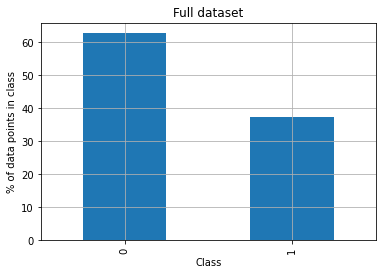

In [ ]:
'''
STEP 2:
Check class distribution
'''

# Class distribution
round((df2['label'].value_counts()/len(df2['label'])) * 100, 2).plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('% of data points in class')
plt.title('Full dataset')
plt.grid()

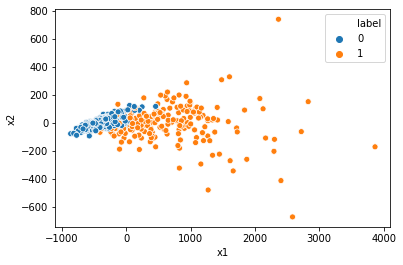

In [ ]:
'''
STEP 3:
Is the dataset linearly separable?
'''

from sklearn.decomposition import PCA
pca = PCA(n_components=3)

pca = pca.fit(X)
pca_df = pca.transform(X)

train_df_viz = pd.concat([pd.DataFrame(pca_df, columns=['x1', 'x2', 'x3']), y], axis=1)
sns.scatterplot(x='x1', y='x2', hue='label', data=train_df_viz)

In [ ]:
'''
STEP 4:
Setup pipeline for models.
'''

#model instantiation
model_names = ['DecisionTree', 'NeuralNet', 'Boosting', 'SVC', 'KNN']
classifiers2 = [
                Pipeline([
                        ('scaler', StandardScaler()),
                        ('dtc', DecisionTreeClassifier(criterion='gini', random_state=1))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('mlp', init_MLPClassifier(l_rate=0.001))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('gbc', GradientBoostingClassifier(random_state=14))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('svc', SVC(C=1, kernel='rbf', random_state=83))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier(n_neighbors=5))
               ])
               ]

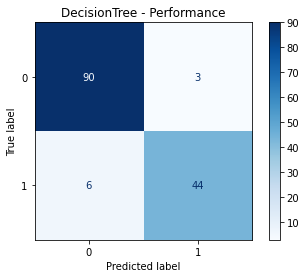

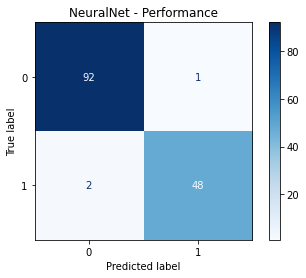

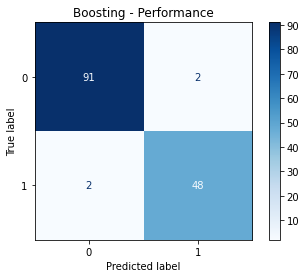

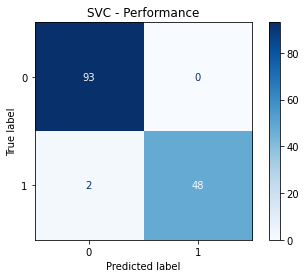

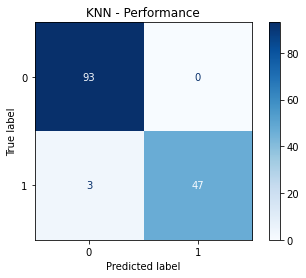

In [ ]:
'''
STEP 5:
Train and evaluate model performance
'''

train_scores = []
test_scores = []
test_auc = []
train_time = []
test_time = []

for name, clf in zip(model_names, classifiers2):
  t0=time()
  clf.fit(X2_train, y2_train)
  train_time.append(round(time()-t0, 3))

  t0=time()
  clf.score(X2_test, y2_test)
  test_time.append(round(time()-t0, 3))

  train_scores.append(clf.score(X2_train, y2_train))
  test_scores.append(clf.score(X2_test, y2_test))
  test_auc.append(roc_auc_score(y2_test, clf.predict(X2_test)))

  disp = plot_confusion_matrix(clf, X2_test, y2_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues
                                #normalize='all'
                                )
  disp.ax_.set_title(name + ' - Performance')

In [ ]:
'''
STEP 6:
Evaluation - Model performance on train and test sets
'''

# Accuracy of models
pd.DataFrame([train_scores, test_scores, test_auc, train_time, test_time], 
             columns=model_names, 
             index=['Train', 'Test', 'ROC_AUC', 'Training Time', 'Test Time']
             )

,DecisionTree,NeuralNet,Boosting,SVC,KNN
Train,1.000000,0.997653,1.000000,0.988263,0.976526
Test,0.937063,0.979021,0.972028,0.986014,0.979021
ROC_AUC,0.923871,0.974624,0.969247,0.980000,0.970000
Training Time,0.019000,0.709000,0.388000,0.007000,0.003000
Test Time,0.002000,0.002000,0.002000,0.002000,0.009000


## Parameter tuning using GridSearch in sklearn.
STEP 7

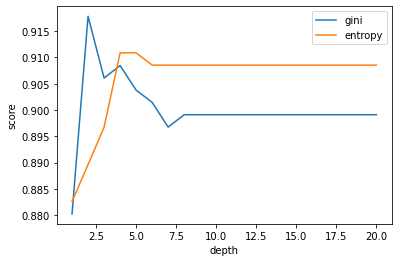

Best parameters:  {'dtc__criterion': 'gini', 'dtc__max_depth': 2}


In [ ]:
'''
DecisionTree tuning
'''
from sklearn.model_selection import GridSearchCV

dt_pipe = Pipeline([
                  ('scaler', StandardScaler()),
                  ('dtc', DecisionTreeClassifier(criterion='gini', random_state=600))  # max_depth=17
               ])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__max_depth': list(range(1, 21))
}
search = GridSearchCV(dt_pipe, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1))
search.fit(X2_train, y2_train)


search.best_estimator_.named_steps['dtc']

# search.score(y2_test, search.predict(X2_test))
# search.cv_results_['mean_test_score']
# [depth for depth in search.cv_results_['param_dtc__max_depth']]

depth = list(range(1, 21))
gini_score = search.cv_results_['mean_test_score'][0:20]
entropy_score = search.cv_results_['mean_test_score'][20:40]

plt.plot(depth, gini_score)
plt.plot(depth, entropy_score)

plt.legend(['gini', 'entropy'], loc='upper right')
plt.xlabel('depth')
plt.ylabel('score')
plt.show()

print('Best parameters: ', search.best_params_)

### Boosting 

In [ ]:
'''
Boosting tuning
'''
dt_pipe =  Pipeline([
                         ('scaler', StandardScaler()),
                         ('gbc', GradientBoostingClassifier(random_state=20))
               ])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'gbc__loss': ['deviance', 'exponential'],
    'gbc__learning_rate': list(np.arange(0.001, 0.1, 0.005))
}
search = GridSearchCV(dt_pipe, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1))
search.fit(X2_train, y2_train)


search.best_estimator_.named_steps['gbc']

print('Best parameters: ', search.best_params_)



Best parameters:  {'gbc__learning_rate': 0.096, 'gbc__loss': 'exponential'}


In [ ]:
'''
NeuralNet tuning
'''

dt_pipe =   Pipeline([
                         ('scaler', StandardScaler()),
                         ('mlp', init_MLPClassifier(max_iter=1000, l_rate=0.001))
               ])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'mlp__learning_rate_init': np.arange(0.001, 0.1, 0.005)
}
search = GridSearchCV(dt_pipe, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=12))
search.fit(X2_train, y2_train)


search.best_estimator_.named_steps['mlp']

print('Best parameters: ', search.best_params_)

Best parameters:  {'mlp__activation': 'relu', 'mlp__learning_rate_init': 0.066}


In [ ]:
'''
SVC tuning
'''
dt_pipe =   Pipeline([
                         ('scaler', StandardScaler()),
                         ('svc', SVC(random_state=200))
               ])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__C': list(range(1,11))
}
search = GridSearchCV(dt_pipe, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True))
search.fit(X2_train, y2_train)


search.best_estimator_.named_steps['svc']

print('Best parameters: ', search.best_params_)

Best parameters:  {'svc__C': 5, 'svc__kernel': 'rbf'}


In [ ]:
'''
KNN tuning
'''

dt_pipe =   Pipeline([
                         ('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier())
               ])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'knn__n_neighbors': list(range(1, 10, 2)),
    'knn__weights': ['uniform', 'distance']
}
search = GridSearchCV(dt_pipe, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True))
search.fit(X2_train, y2_train)


search.best_estimator_.named_steps['knn']

print('Best parameters: ', search.best_params_)

Best parameters:  {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}


In [ ]:
'''
STEP 8
Setup the models pipelines with tuned parameters
'''
#model instantiation
model_names = ['DecisionTree', 'NeuralNet', 'Boosting', 'SVC', 'KNN']
classifiers2 = [
               Pipeline([
                        ('scaler', StandardScaler()),
                        ('dtc', DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=310))  # max_depth=17
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('mlp', init_MLPClassifier(activation='relu', l_rate=0.066, rand_state=300))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('gbc', GradientBoostingClassifier(loss='exponential', learning_rate=0.96, random_state=230))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('svc', SVC(C=5, kernel='rbf', random_state=200))
               ]),
               Pipeline([
                         ('scaler', StandardScaler()),
                         ('knn', KNeighborsClassifier(n_neighbors=7, weights='uniform'))
               ])
               ]

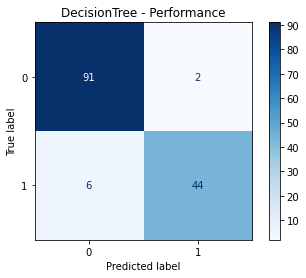

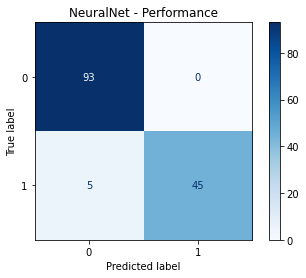

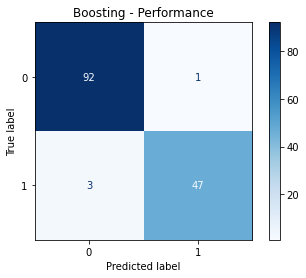

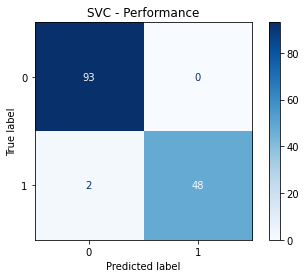

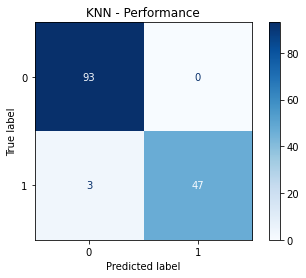

In [ ]:
'''
STEP 9:
Train and evaluate performance of tuned models
'''

train_scores = []
test_scores = []
test_auc = []
train_time = []
test_time = []

for name, clf in zip(model_names, classifiers2):
  t0=time()
  clf.fit(X2_train, y2_train)
  train_time.append(round(time()-t0, 3))

  t0=time()
  clf.score(X2_test, y2_test)
  test_time.append(round(time()-t0, 3))

  train_scores.append(clf.score(X2_train, y2_train))
  test_scores.append(clf.score(X2_test, y2_test))
  test_auc.append(roc_auc_score(y2_test, clf.predict(X2_test)))

  disp = plot_confusion_matrix(clf, X2_test, y2_test,
                                 display_labels=[0, 1],
                                 cmap=plt.cm.Blues
                                #normalize='all'
                                )
  disp.ax_.set_title(name + ' - Performance')

In [ ]:
'''
STEP 10:
Evaluation - Model performance on train and test sets
'''

# Accuracy of models
pd.DataFrame([train_scores, test_scores, test_auc, train_time, test_time], 
             columns=model_names, 
             index=['Train', 'Test', 'ROC_AUC', 'Training Time', 'Test Time']
             )

,DecisionTree,NeuralNet,Boosting,SVC,KNN
Train,0.953052,0.990610,1.000000,0.992958,0.971831
Test,0.944056,0.965035,0.972028,0.986014,0.979021
ROC_AUC,0.929247,0.950000,0.964624,0.980000,0.970000
Training Time,0.010000,0.059000,0.164000,0.007000,0.003000
Test Time,0.002000,0.002000,0.002000,0.002000,0.009000
